In [76]:
import pandas as pd
import numpy as np

In [77]:
df0 = pd.read_csv("Noah_5Years_000.csv", skiprows=4)
df1 = pd.read_csv("Noah_5Years_002.csv", skiprows=4)
df2 = pd.read_csv("Noah_5Years_003.csv", skiprows=4)

df = pd.concat([df0, df1, df2])
df = df[['Timestamp', 'Noah - Water Use (gal)']]
df[['Date', 'Time']] = df['Timestamp'].str.split(' ', expand = True)
df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day_name()
df = df[['Date', 'Year', 'Month', 'Day', 'Time', 'Noah - Water Use (gal)']]
df.columns = ['Date', 'Year', 'Month', 'Day', 'Time', 'Water']

df.dropna(inplace=True)

df['Time'] = pd.to_datetime(df['Time']).dt.time

from datetime import time
df = df[df['Time'] >= time(8)]      #Exclude timestamp before 8 am

df = df.reset_index(drop=True)


#Test set: Year 2022
start = df[df['Date'] == '2022-01-01'].iloc[0].name
end = df[df['Date'] == '2022-12-31'].iloc[-1].name
df_test = df.iloc[start: end]
df_train = df.iloc[: start]

df_train = df_train[['Month', 'Day', 'Time', 'Water']]

df_train      #Final dataset

,Month,Day,Time,Water
0,1,Monday,08:00:00,0.00000
1,1,Monday,08:15:00,0.00000
2,1,Monday,08:30:00,0.00000
3,1,Monday,08:45:00,0.00000
4,1,Monday,09:00:00,0.00000
...,...,...,...,...
58063,12,Friday,22:45:00,2.28294
58064,12,Friday,23:00:00,4.01284
58065,12,Friday,23:15:00,7.57591
58066,12,Friday,23:30:00,0.27672


In [78]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

X = df_train.drop('Water', axis=1)
y = df_train['Water']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
transformer = OneHotEncoder()
X_train_transformed = transformer.fit_transform(X_train)
X_test_transformed = transformer.transform(X_test)

In [79]:
rgs = MLPRegressor(hidden_layer_sizes=(10,))
rgs.fit(X_train_transformed, y_train)
y_pred = rgs.predict(X_test_transformed)

c:\Users\admin\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [80]:
from sklearn.metrics import r2_score
r2_score(y_test, y_pred)

0.2779718172694329

In [81]:
df_test = df_test.reset_index(drop=True)
df_test.columns = ['Date', 'Year',	'Month',	'Day',	'Time',	'Water']
df_test

,Date,Year,Month,Day,Time,Water
0,2022-01-01,2022,1,Saturday,08:00:00,1.59134
1,2022-01-01,2022,1,Saturday,08:15:00,0.24213
2,2022-01-01,2022,1,Saturday,08:30:00,0.65721
3,2022-01-01,2022,1,Saturday,08:45:00,0.17295
4,2022-01-01,2022,1,Saturday,09:00:00,0.20754
...,...,...,...,...,...,...
23316,2022-12-31,2022,12,Saturday,22:30:00,1.34901
23317,2022-12-31,2022,12,Saturday,22:45:00,0.86475
23318,2022-12-31,2022,12,Saturday,23:00:00,3.35533
23319,2022-12-31,2022,12,Saturday,23:15:00,2.83638


In [82]:
b = df_test.groupby('Date').apply(lambda d: d.iloc[d['Water'].argsort()[:10]]['Time']) 
b

Date             
2022-01-01  31       15:45:00
            3        08:45:00
            20       13:00:00
            4        09:00:00
            23       13:45:00
                       ...   
2022-12-31  23314    22:00:00
            23320    23:30:00
            23304    19:30:00
            23309    20:45:00
            23311    21:15:00
Name: Time, Length: 3650, dtype: object

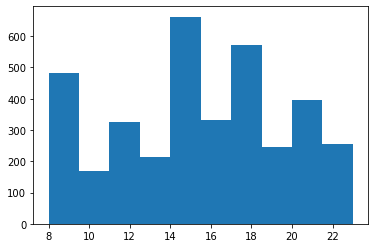

In [83]:
import matplotlib.pyplot as plt
plt.figure()
c = b.apply(lambda x: x.hour)
plt.hist(c)
plt.show()

In [84]:
X_test1 = df_test[['Month', 'Day', 'Time']]
X_test1_tranformed = OneHotEncoder().fit_transform(X_test1)
X_test1['Water'] = rgs.predict(X_test1_tranformed)
X_test1['Date'] = df_test['Date']
a = X_test1.groupby('Date').apply(lambda d: d.iloc[d['Water'].argsort()[:10]]['Time']) 
print(a.head(20))

C:\Users\admin\AppData\Local\Temp\ipykernel_4076\1073370504.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test1['Water'] = rgs.predict(X_test1_tranformed)
C:\Users\admin\AppData\Local\Temp\ipykernel_4076\1073370504.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test1['Date'] = df_test['Date']


Date           
2022-01-01  0      08:00:00
            1      08:15:00
            43     18:45:00
            2      08:30:00
            29     15:15:00
            3      08:45:00
            42     18:30:00
            4      09:00:00
            34     16:30:00
            39     17:45:00
2022-01-02  64     08:00:00
            65     08:15:00
            93     15:15:00
            107    18:45:00
            66     08:30:00
            67     08:45:00
            106    18:30:00
            68     09:00:00
            98     16:30:00
            103    17:45:00
Name: Time, dtype: object


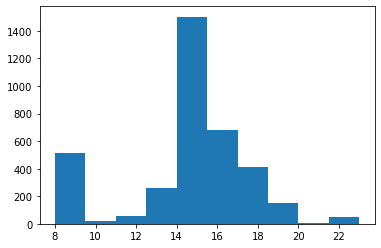

In [85]:
plt.figure()
c = a.apply(lambda x: x.hour)
plt.hist(c)
plt.show()

In [86]:
from datetime import datetime
from datetime import timedelta
def get_3best_time(month=datetime.now().month, day=datetime.now().day, earliest='08:00', latest='23:45', trained_model=rgs):
    earliest = datetime.strptime(earliest, '%H:%M')
    latest = datetime.strptime(latest, '%H:%M')

    time_array = []
    while True:
        time_array.append(earliest.time())
        if earliest == latest:
            break
        earliest += timedelta(minutes=15)
        
    cur_X = pd.DataFrame({'Month': month, 'Day': datetime(datetime.now().year, month, day).strftime('%A'), 'Time': time_array})
    cur_X_transformed = transformer.transform(cur_X)
    y = trained_model.predict(cur_X_transformed)
    cur_X['Water'] = trained_model.predict(cur_X_transformed)
    top_3 = cur_X.iloc[cur_X['Water'].argsort()[:3]]
    return top_3[['Time', 'Water']].reset_index(drop=True)
get_3best_time()    

,Time,Water
0,15:15:00,4.253395
1,15:45:00,5.371525
2,14:00:00,5.475105


In [87]:
month = 1
day = 24
get_3best_time(1, 24, '19:00', '22:00') 

,Time,Water
0,19:00:00,7.543959
1,19:15:00,7.953234
2,19:30:00,8.024566


In [99]:
agg_df = df.groupby(['Day', 'Time']).agg({'Water': 'mean'})

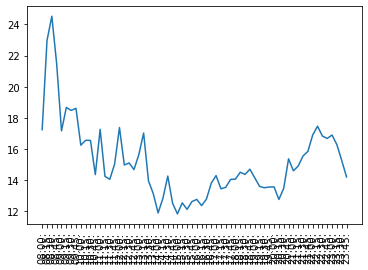

In [131]:
fri = agg_df.loc['Friday']

timestamps = []
for timestamp in fri.index:
    timestamps.append(str(timestamp)[:-2])
plt.figure()
plt.plot(timestamps, fri['Water'])
plt.xticks(rotation=90)
# plt.ylim(0, 30)
plt.show()

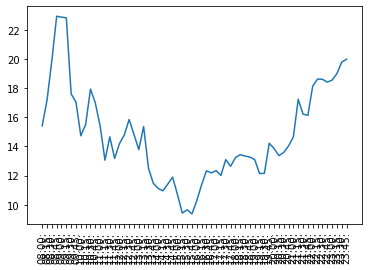

In [132]:
thu = agg_df.loc['Thursday']

plt.figure()
plt.plot(timestamps, thu['Water'])
plt.xticks(rotation=90)
# plt.ylim(0, 30)
plt.show()